<a href="https://colab.research.google.com/github/chuuuuu/machine_learning_2021/blob/main/homework/hw05/hw05_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 5 - Sequence-to-sequence**

If you have any questions, feel free to email us at: ntu-ml-2021spring-ta@googlegroups.com

- Link to [tutorial]() (TBA).

# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Fri Jul  2 20:50:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download and import required packages

In [3]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 901kB 19.7MB/s 
     |████████████████████████████████| 1.2MB 34.5MB/s 
     |████████████████████████████████| 1.8MB 49.0MB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 174kB 50.3MB/s 
     |████████████████████████████████| 133kB 47.6MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=69df92f1abff53d07a011de94fe056585e0ef7a3125d9caecd879f0ce173b65e
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=1badc145fb50af3b725954450b8d6c9cd97f3b06647f6bc12422f482cc342afa
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subp

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Configuration for Experiments

In [12]:
WORKSPACE = './gdrive/MyDrive/ColabNotebooks/HW5'

config = Namespace(
    # dir structure
    save_dir = f'{WORKSPACE}/checkpoints/ft',
    data_dir = f'{WORKSPACE}/data/bin/ted2020_with_synthetic',

    # if you want to train a back-translation model, exchange the string below two line    
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=60,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Fix random seed

In [6]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [7]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environment

In [8]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-07-02 20:54:43 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-07-02 20:54:43 | INFO | fairseq.utils | rank   0: capabilities =  7.0  ; total memory = 15.782 GB ; name = Tesla V100-SXM2-16GB                    
2021-07-02 20:54:43 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [13]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.data_dir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-07-02 20:55:37 | INFO | fairseq.tasks.translation | [en] dictionary: 15992 types
2021-07-02 20:55:37 | INFO | fairseq.tasks.translation | [zh] dictionary: 15992 types


In [14]:
logger.info("loading data for epoch 1")
task.load_dataset(split="mono", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-07-02 20:55:41 | INFO | hw5.seq2seq | loading data for epoch 1
2021-07-02 20:55:44 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/mono.zh-en.en
2021-07-02 20:55:47 | INFO | fairseq.data.data_utils | loaded 782,527 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/mono.zh-en.zh
2021-07-02 20:55:47 | INFO | fairseq.tasks.translation | ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic mono en-zh 782527 examples
2021-07-02 20:55:50 | INFO | fairseq.data.data_utils | loaded 388,365 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/train.zh-en.en
2021-07-02 20:55:52 | INFO | fairseq.data.data_utils | loaded 388,365 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/train.zh-en.zh
2021-07-02 20:55:52 | INFO | fairseq.tasks.translation | ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_

In [15]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 3523, 10027,    32,    19,    13,     8,    15,  2009,   200,     2]),
 'target': tensor([ 5846, 12913,   927,  6021,   308,    32,   120,  2002,   191,   756,
          200,     2])}
"Source: chris anderson: it's a deal !"
'Target: 克里斯・安徒生:一言為定 !'


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [16]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-07-02 20:56:06 | WARNING | fairseq.tasks.fairseq_task | 2,049 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[2580, 2270, 3771, 3082, 3081, 791, 437, 1279, 994, 391]


{'id': tensor([705]),
 'net_input': {'prev_output_tokens': tensor([[   2,   47, 2001,  591,  333, 2171,  375,  825, 4714, 1936,  234, 1302,
              1,    1,    1,    1]]),
  'src_lengths': tensor([14]),
  'src_tokens': tensor([[    1,     1,    29,    57,   976,  1485,   148,    42,   924,    11,
             167,    49,   148, 12127,     5,     2]])},
 'nsentences': 1,
 'ntokens': 12,
 'target': tensor([[  47, 2001,  591,  333, 2171,  375,  825, 4714, 1936,  234, 1302,    2,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [17]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [18]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [19]:
# HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [20]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [21]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [22]:
model = build_model(arch_args, task)
logger.info(model)

2021-07-02 20:56:31 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(15992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bi

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [23]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [24]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

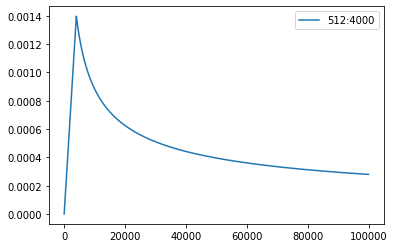

In [25]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [26]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [27]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [28]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [29]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.save_dir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.save_dir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [30]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [31]:
!nvidia-smi

Fri Jul  2 20:57:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    40W / 300W |   1579MiB / 16160MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-07-02 20:57:12 | INFO | hw5.seq2seq | task: TranslationTask
2021-07-02 20:57:12 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-07-02 20:57:12 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-07-02 20:57:12 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-07-02 20:57:12 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-07-02 20:57:12 | INFO | hw5.seq2seq | num. model params: 60,516,352 (num. trained: 60,516,352)
2021-07-02 20:57:12 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [33]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-07-02 20:57:14 | INFO | hw5.seq2seq | no checkpoints found at gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/ft/checkpoint_last.pt!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


2021-07-02 21:05:12 | INFO | hw5.seq2seq | training loss: 6.7652
2021-07-02 21:05:12 | INFO | hw5.seq2seq | begin validation


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


2021-07-02 21:05:38 | INFO | hw5.seq2seq | example source: and so you want that to tow boats very fast .
2021-07-02 21:05:38 | INFO | hw5.seq2seq | example hypothesis: 所以 , 你想把船上 , 快快快快了 。
2021-07-02 21:05:38 | INFO | hw5.seq2seq | example reference: 只有這樣你才能很快地拉動一條船 。
2021-07-02 21:05:38 | INFO | hw5.seq2seq | validation loss:	5.4483
2021-07-02 21:05:38 | INFO | hw5.seq2seq | BLEU = 9.17 35.6/14.4/6.0/2.7 (BP = 0.957 ratio = 0.958 hyp_len = 105525 ref_len = 110121)
2021-07-02 21:05:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/ft/checkpoint1.pt
2021-07-02 21:05:41 | INFO | hw5.seq2seq | end of epoch 1


KeyboardInterrupt: ignored

# Submission

In [34]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.save_dir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/ft'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/ft/avg_last_5_checkpoint.pt')
Traceback (most recent call last):
  File "./fairseq/scripts/average_checkpoints.py", line 158, in <module>
    main()
  File "./fairseq/scripts/average_checkpoints.py", line 147, in main
    upper_bound=args.checkpoint_upper_bound,
  File "./fairseq/scripts/average_checkpoints.py", line 94, in last_n_checkpoints
    "Found {} checkpoint files but need at least {}", len(entries), n
Exception: ('Found {} checkpoint files but need at least {}', 1, 5)


## Confirm model weights used to generate submission

In [35]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="checkpoint_best.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-07-02 21:07:04 | INFO | hw5.seq2seq | loaded checkpoint gdrive/MyDrive/ColabNotebooks/HW5/checkpoints/ft/checkpoint_best.pt: step=unknown loss=5.448311805725098 bleu=9.172592232828011
2021-07-02 21:07:04 | INFO | hw5.seq2seq | begin validation


2021-07-02 21:07:31 | INFO | hw5.seq2seq | example source: and we started asking them all questions .
2021-07-02 21:07:31 | INFO | hw5.seq2seq | example hypothesis: 然後我們開始問所有問題 。
2021-07-02 21:07:31 | INFO | hw5.seq2seq | example reference: 所以我們開始問他們問題 ,
2021-07-02 21:07:31 | INFO | hw5.seq2seq | validation loss:	5.4483
2021-07-02 21:07:31 | INFO | hw5.seq2seq | BLEU = 9.17 35.6/14.4/6.0/2.7 (BP = 0.957 ratio = 0.958 hyp_len = 105525 ref_len = 110121)


## Generate Prediction

In [36]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [37]:
generate_prediction(model, task)

2021-07-02 21:07:49 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/test.zh-en.en
2021-07-02 21:07:50 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic/test.zh-en.zh
2021-07-02 21:07:50 | INFO | fairseq.tasks.translation | ./gdrive/MyDrive/ColabNotebooks/HW5/data/bin/ted2020_with_synthetic test en-zh 4000 examples


# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html